## CNN 기본 만들기

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

# STEP 01
1) Torch.cuda.is_available() : 가능한 gpu가 있는지 확인해서 train에 이용할 device 결정\
2) BATCH_SIZE, EPOCHS 등 하이퍼파라미터 결정

In [2]:
if torch.cuda.is_available() :
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')

print('Using PyTorch version  : ', torch.__version__, ' Device : ', DEVICE)

Using PyTorch version  :  1.9.0+cu111  Device :  cuda


In [17]:
BATCH_SIZE = 128
EPOCHS = 20

# STEP 02
1) dataset 과 dataloader 준비
   - Data Augmentation 추가
2) 데이터 확인하기

In [18]:
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                               train = True,
                               download = True,
                               transform = transforms.Compose([
                                   transforms.RandomHorizontalFlip(), # 50% 확률로 좌우 반전
                                   transforms.ToTensor(), # 0~1 의 값들로 정규화 시키며 tensor로 만듦
                                   transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # red, green, blue 순의 또다른 정규화, 각각 평균[R,G,B]과 표준편차[R,G,B]
                               ]))
test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                              train = False,
                              download = True,
                              transform = transforms.Compose([
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                              ]))
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
for (X_train, y_train) in train_loader :
    print('X_train : ', X_train.size(), ' type : ', X_train.type())
    print('y_train : ', y_train.size(), ' type : ', y_train.type())
    break

X_train :  torch.Size([128, 3, 32, 32])  type :  torch.FloatTensor
y_train :  torch.Size([128])  type :  torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

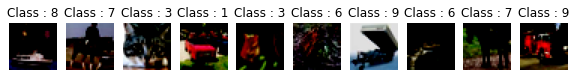

In [20]:
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))
for i in range(10) :
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class : ' + str(y_train[i].item()))

# STEP 03
1) 모델 구조 정의하기
2) optimizer, loss function 정의하기

In [21]:
class CNN(nn.Module) :
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels= 3,
            out_channels= 8,
            kernel_size= 3,
            padding= 1)
        self.conv2 = nn.Conv2d(
            in_channels= 8,
            out_channels= 16,
            kernel_size= 3,
            padding = 1)
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride= 2
        )
        self.fc1 = nn.Linear(8*8*16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        # input : 32 * 32 * 3
        x = self.conv1(x) # 32 * 32 * 8
        x = F.relu(x)
        x = self.pool(x) # 16 * 16 * 8
        x = self.conv2(x) # 16 * 16 * 16
        x = F.relu(x)
        x = self.pool(x) # final output : 8 * 8 * 16

        x = x.view(-1, 8*8*16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [22]:
model = CNN().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # optimizer 를 Adam 으로 진행
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


# STEP 04
- train 코드

In [23]:
def train(model, train_loader, optimizer, log_interval) :
    model.train() # model의 상위 클래스 속 변수 self.training = True 로 만들어주기
    for batch_idx, (image, label) in enumerate(train_loader) :
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        output = model(image)

        loss = criterion(output, label)
        optimizer.zero_grad() # 이전에 학습할 때 저장된 gradient 없애기
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch : {} [ {}/{} ({:.0f}%) ]\tTrain Loss : {:.6f}".format(
                Epoch, batch_idx * len(image), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

# STEP 05
- evaluate 코드

In [24]:
def evaluate(model, test_loader) :
    model.eval() # model의 상위 클래스 속 변수 self.training = False 로 만들어주기
    test_loss = 0
    correct = 0

    with torch.no_grad() : #train 단계가 아니라 eval 단계이므로 gradient update 못하게 방지
        for image, label in test_loader :
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    return test_loss, test_accuracy

#STEP 06
- Train 및 Test 하기

In [25]:
for Epoch in range(1, EPOCHS+1) :
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[Epochh : {}], \tTest Loss : {:.4f}, \tTest Accurary : {:.2f} % \n"
        .format(Epoch, test_loss, test_accuracy))

/tmp/ipykernel_27754/3068725742.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch : 1 [ 0/50000 (0%) ]	Train Loss : 2.320612
Train Epoch : 1 [ 25600/50000 (51%) ]	Train Loss : 1.609035

[Epochh : 1], 	Test Loss : 1.4251, 	Test Accurary : 47.71 % 

Train Epoch : 2 [ 0/50000 (0%) ]	Train Loss : 1.443169
Train Epoch : 2 [ 25600/50000 (51%) ]	Train Loss : 1.397426

[Epochh : 2], 	Test Loss : 1.3327, 	Test Accurary : 52.50 % 

Train Epoch : 3 [ 0/50000 (0%) ]	Train Loss : 1.326783
Train Epoch : 3 [ 25600/50000 (51%) ]	Train Loss : 1.223923

[Epochh : 3], 	Test Loss : 1.2617, 	Test Accurary : 53.89 % 

Train Epoch : 4 [ 0/50000 (0%) ]	Train Loss : 1.476753
Train Epoch : 4 [ 25600/50000 (51%) ]	Train Loss : 1.218293

[Epochh : 4], 	Test Loss : 1.1717, 	Test Accurary : 57.97 % 

Train Epoch : 5 [ 0/50000 (0%) ]	Train Loss : 1.200334
Train Epoch : 5 [ 25600/50000 (51%) ]	Train Loss : 1.009418

[Epochh : 5], 	Test Loss : 1.1344, 	Test Accurary : 58.88 % 

Train Epoch : 6 [ 0/50000 (0%) ]	Train Loss : 1.060952
Train Epoch : 6 [ 25600/50000 (51%) ]	Train Loss : 1.16